In [6]:
BASE_PATH = '/content/drive/My Drive/Universidad/Semestre 2020-2/Tecnicas de Aprendizaje Estadistico/accidentalidad-medellin'
SHARED_PATH = '/content/drive/Shared drives/accidentalidad-medellin'

import pandas as pd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy as np
import matplotlib.pyplot as plt
import json

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Leamos las bases de datos

In [8]:
incidentes_2014 = pd.read_csv(BASE_PATH + '/data/Incidentes_georreferenciados_2014.csv')
incidentes_2015 = pd.read_csv(BASE_PATH + '/data/Incidentes_georreferenciados_2015.csv')
incidentes_2016 = pd.read_csv(BASE_PATH + '/data/Incidentes_georreferenciados_2016.csv')
incidentes_2017 = pd.read_csv(BASE_PATH + '/data/Incidentes_georreferenciados_2017.csv')
incidentes_2018 = pd.read_csv(BASE_PATH + '/data/Incidentes_georreferenciados_2018.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Veamos para cada uno de los años, cuantos y que datos faltantes hay en cada columna

In [9]:
    datos_faltantes = pd.DataFrame([
        incidentes_2014.isna().sum().to_dict(),
        incidentes_2015.isna().sum().to_dict(),
        incidentes_2016.isna().sum().to_dict(),
        incidentes_2017.isna().sum().to_dict(),
        incidentes_2018.isna().sum().to_dict(),
    ], index = ['2014', '2015', '2016', '2017', '2018'])
    datos_faltantes

,X,Y,OBJECTID,RADICADO,FECHA,HORA,DIA,PERIODO,CLASE,DIRECCION,DIRECCION_ENC,CBML,TIPO_GEOCOD,GRAVEDAD,BARRIO,COMUNA,DISENO,DIA_NOMBRE,MES,MES_NOMBRE,X_MAGNAMED,Y_MAGNAMED,LONGITUD,LATITUD
2014,0,0,0,0,0,0,0,0,0,0,315,4305,0,0,4305,4305,282,0,0,45755,0,0,0,0
2015,0,0,0,0,0,0,0,0,1,0,381,4206,0,0,4206,4206,266,0,0,46172,0,0,0,0
2016,0,0,0,0,0,0,0,0,5,0,270,4372,0,0,4372,4372,258,0,0,47101,0,0,0,0
2017,0,0,0,2,0,0,0,0,0,0,134,3711,0,0,3713,3710,254,0,0,46210,0,0,0,0
2018,0,0,0,3,0,0,0,0,0,0,141,3163,0,0,3170,3143,224,0,0,43455,0,0,0,0


Carreta 

## Agregar datos para la columna MES_NOMBRE

Note que el conjunto de datos tiene una variable llamada 'MES', esta es numérica y representa el mes de cada accidente. Con esta columna se obtiene el nombre del mes.


In [10]:
meses = ('Enero', 'Febero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 
        'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre')
incidentes_2014['MES_NOMBRE'] = (incidentes_2014['MES'] - 1).map(meses.__getitem__)
incidentes_2015['MES_NOMBRE'] = (incidentes_2015['MES'] - 1).map(meses.__getitem__)
incidentes_2016['MES_NOMBRE'] = (incidentes_2016['MES'] - 1).map(meses.__getitem__)
incidentes_2017['MES_NOMBRE'] = (incidentes_2017['MES'] - 1).map(meses.__getitem__)
incidentes_2018['MES_NOMBRE'] = (incidentes_2018['MES'] - 1).map(meses.__getitem__)

## Barrios, comunas y CBML

Note que en los diferentes conjuntos, la cantidad de datos que faltan en estas columnas es igual (con excepción de los años 2016 2017).

### Comunas

En medellín existen 16 comunas y 5 corregimientos, es decir que para este dato se disponen de 21 opciones. Por supuesto, podrían aparecer 22 contando los NA.

In [11]:
incidentes_2014['COMUNA'].unique()

array(['Belén', 'La Candelaria', 'Manrique', 'Doce de Octubre',
       'Aranjuez', 'Buenos Aires', 'Laureles Estadio', 'El Poblado', nan,
       'Castilla', 'Popular', 'Robledo',
       'Corregimiento de San Antonio de Prado',
       'Corregimiento de San Cristóbal', 'La América', 'San Javier',
       'Guayabal', 'Villa Hermosa', 'Santa Cruz',
       'Corregimiento de Altavista', 'Corregimiento de Santa Elena', 'In',
       'AU', 'SN'], dtype=object)

Como se puede ver, los datos contienen 24 datos, de los cuales se contempla el NA, y 3 valores extraños: In, AU, SN.

In [12]:
incidentes_2015['COMUNA'].unique()

array(['Castilla', 'Manrique', 'Belén', 'Aranjuez', nan, 'Santa Cruz',
       'Robledo', 'Popular', 'Doce de Octubre', 'Guayabal', 'El Poblado',
       'Villa Hermosa', 'San Javier', 'La América', 'La Candelaria',
       'Corregimiento de San Cristóbal', 'Laureles Estadio',
       'Buenos Aires', 'Corregimiento de Santa Elena',
       'Corregimiento de Altavista',
       'Corregimiento de San Antonio de Prado',
       'Corregimiento de San Sebastián de Palmitas', 'In', 'AU', 'SN',
       '0'], dtype=object)

En este caso se tiene que se agrega un valor más ("0") que es ajeno a las posibles opciones

In [13]:
incidentes_2016['COMUNA'].unique()

array(['Santa Cruz', 'Corregimiento de San Cristóbal', nan,
       'Doce de Octubre', 'Laureles Estadio', 'El Poblado', 'Aranjuez',
       'La Candelaria', 'Belén', 'Corregimiento de San Antonio de Prado',
       'Castilla', 'San Javier', 'Robledo', 'Buenos Aires', 'Manrique',
       'Corregimiento de Santa Elena', 'Villa Hermosa', 'La América',
       'Guayabal', 'Popular', 'Corregimiento de Altavista', 'In',
       'Corregimiento de San Sebastián de Palmitas', '0', 'AU'],
      dtype=object)

se presenta el mismo caso anterior.

In [14]:
incidentes_2017['COMUNA'].unique()

array(['La América', 'Doce de Octubre', 'Laureles Estadio', nan,
       'Guayabal', 'Popular', 'Castilla',
       'Corregimiento de San Antonio de Prado', 'El Poblado',
       'La Candelaria', 'Corregimiento de San Cristóbal', 'Robledo',
       'Belén', 'Villa Hermosa', 'Aranjuez', 'Manrique', 'San Javier',
       'Buenos Aires', 'Santa Cruz', 'Corregimiento de Santa Elena',
       'Corregimiento de Altavista', 'In',
       'Corregimiento de San Sebastián de Palmitas', 'AU', 'Caribe',
       'La Alpujarra', 'Boston', 'El Nogal-Los Almendros',
       'Antonio Nariño', 'Parque Juan Pablo II', 'Bolivariana',
       'Cristo Rey', 'La Floresta', 'Santa Inés', 'Santa Fé', 'Fátima',
       'Oleoducto', 'Suramericana', 'Naranjal', 'Perpetuo Socorro',
       'Rosales', 'San Pedro', 'Guayaquil',
       'Cabecera San Antonio de Prado', 'El Chagualo', 'La Rosa',
       'Patio Bonito', 'Toscana', 'Las Esmeraldas', 'Florida Nueva',
       'Héctor Abad Gómez', 'Santa María de los Ángeles', 'Villa Car

Nótese que en este caso, se introdujeron nombres de barrios en lo que debería ser los nombres de las comunas asociadas.

In [15]:
incidentes_2018['COMUNA'].unique()

array(['Castilla', nan, 'Robledo', 'El Poblado', 'La Candelaria',
       'Aranjuez', 'Belén', 'Guayabal', 'Laureles Estadio',
       'Doce de Octubre', 'Villa Hermosa', 'Manrique', 'San Javier',
       'La América', 'Popular', 'Buenos Aires',
       'Corregimiento de San Antonio de Prado', 'Santa Cruz',
       'Corregimiento de San Cristóbal', 'In',
       'Corregimiento de Altavista', 'Corregimiento de Santa Elena', 'AU',
       'Corregimiento de San Sebastián de Palmitas'], dtype=object)

En este caso solo se tienen dos valores extraños.

En resumen, se tiene que los nombres de las diferentes comunas están estandariazados, se tiene el valor NA, hay 4 valores extraños (AU, In, SN, 0). Y para el año 2017 se introdujeron barrios con comunas, por lo que hay que hacer una reparación para este año.

### Arreglar Bario y Comunas faltates segun sus coordenadas geograficas

Ya que contamos con los datos de localizacion geografica para la frontera de cada uno de los barrios, podremos deliminar los barrios como regiones y un punto
dentro de esta region correspondera a una ubicacion dentro del barrio para el que ya se sabe cual es su comuna.

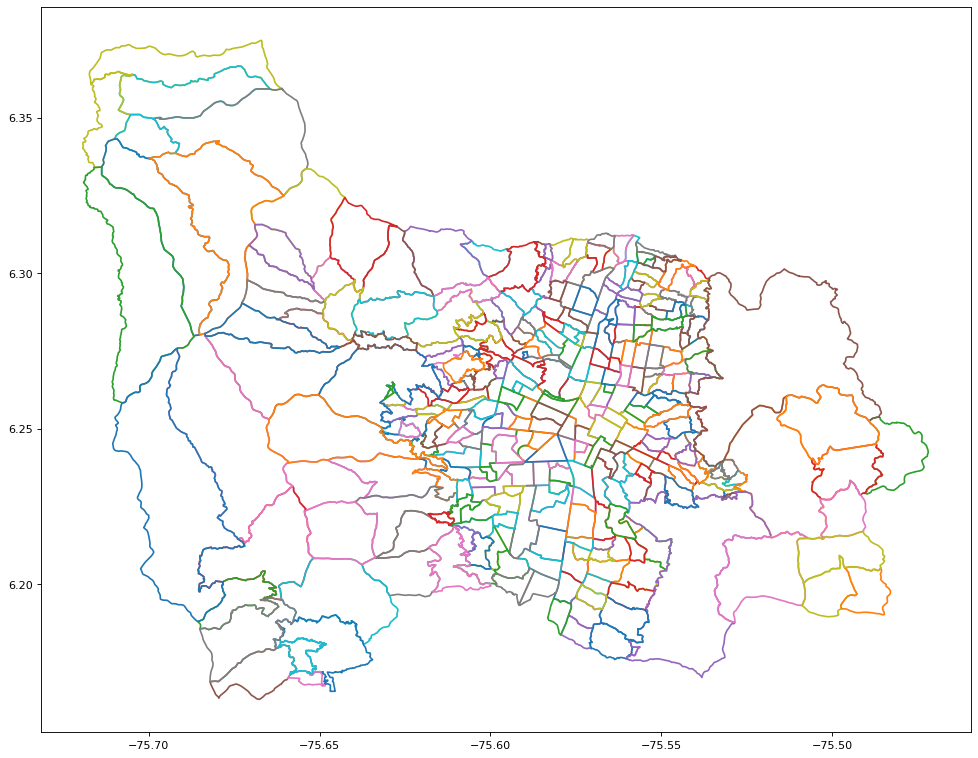

In [16]:
poligonos = []
with open(BASE_PATH + '/data/Rings.json', 'r') as f:
    raw_poligonos = json.loads(f.readline())
    for feature in raw_poligonos['features']:
        poligonos.append({
            'barrio': feature['attributes']['NOMBRE'],
            'comuna': feature['attributes']['NOMBRE_COMUNA_CORREGIMIENTO'],
            'geometry': feature['geometry']['rings'][0]
        })
barrios = []
for poligono in poligonos:
    lons = []
    lats = []
    for lon, lat in poligono['geometry']:
        lons.append(lon)
        lats.append(lat)
    lons_lats_vect = np.column_stack((lons, lats))
    barrios.append({
        'barrio': poligono['barrio'],
        'comuna': poligono['comuna'],
        'poligono': Polygon(lons_lats_vect),
    })

def mapa_medellin(color = None, w = 15, h = 12):
    plt.figure(num=None, figsize=(w, h), dpi=80, facecolor='w', edgecolor='k')
    for barrio in barrios:
        cx,cy = barrio['poligono'].exterior.xy
        plt.plot(cx,cy, c=color)

def is_on_polygon(point, polygon):
    return polygon.contains(point) or polygon.touches(point)

mapa_medellin()
plt.show()

Con lo anterior, cada region cuenta con su respectivo barrio, comuna y poligono, con esto, para los datos que no cuentan co barrio ni comuna, les asignaremos el barrio y comuna correspondiente ubicacion geografica.

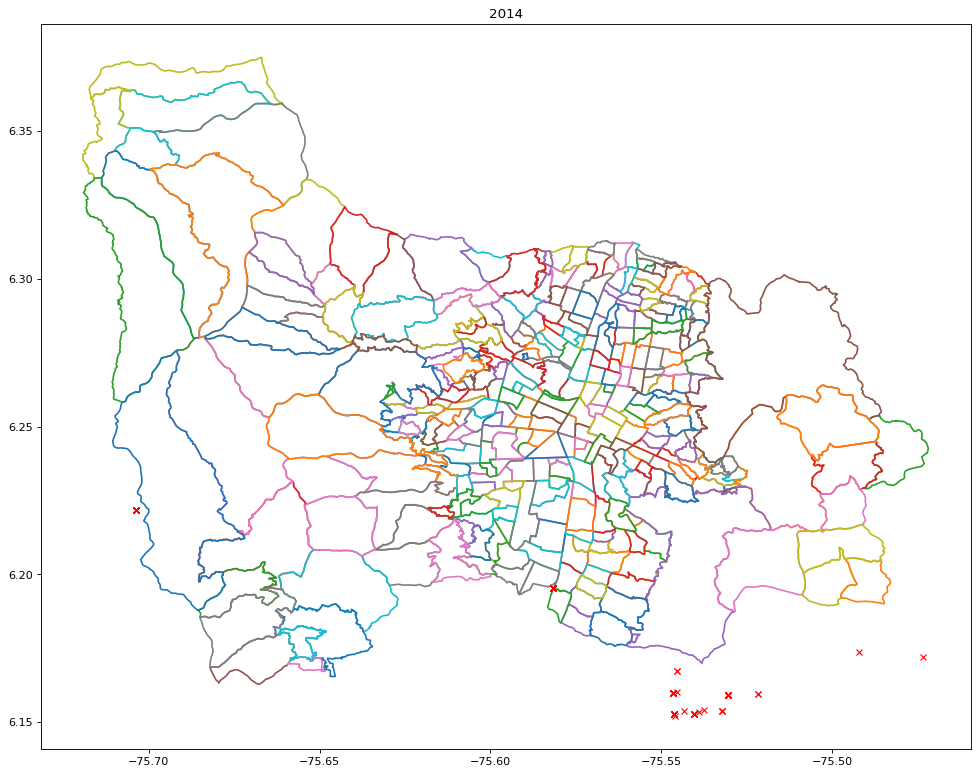

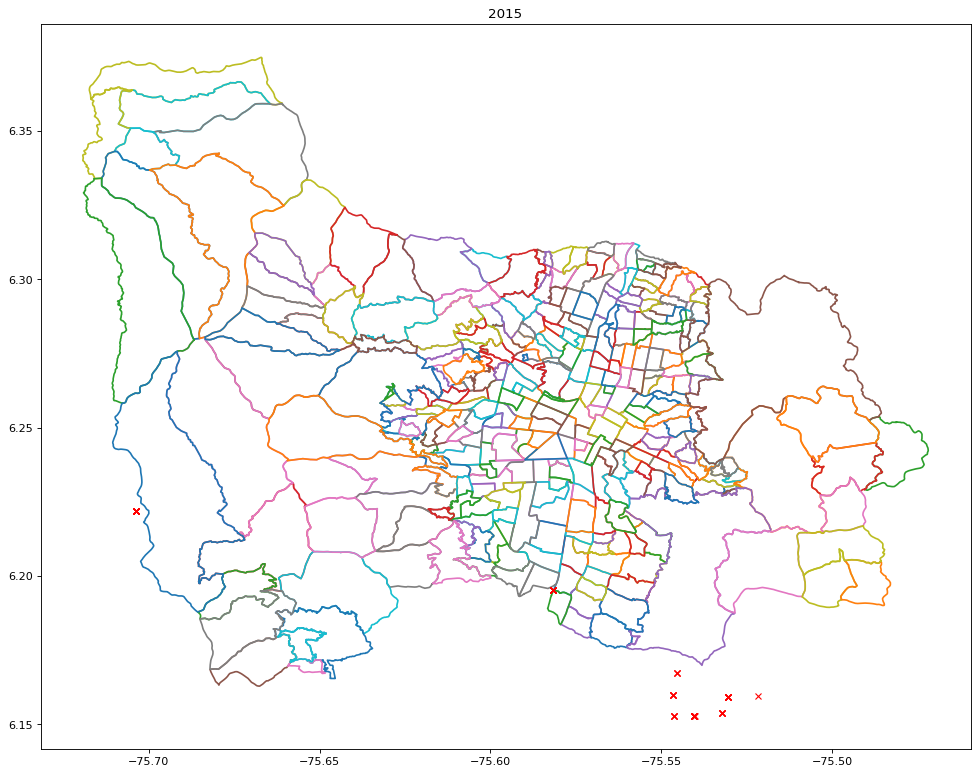

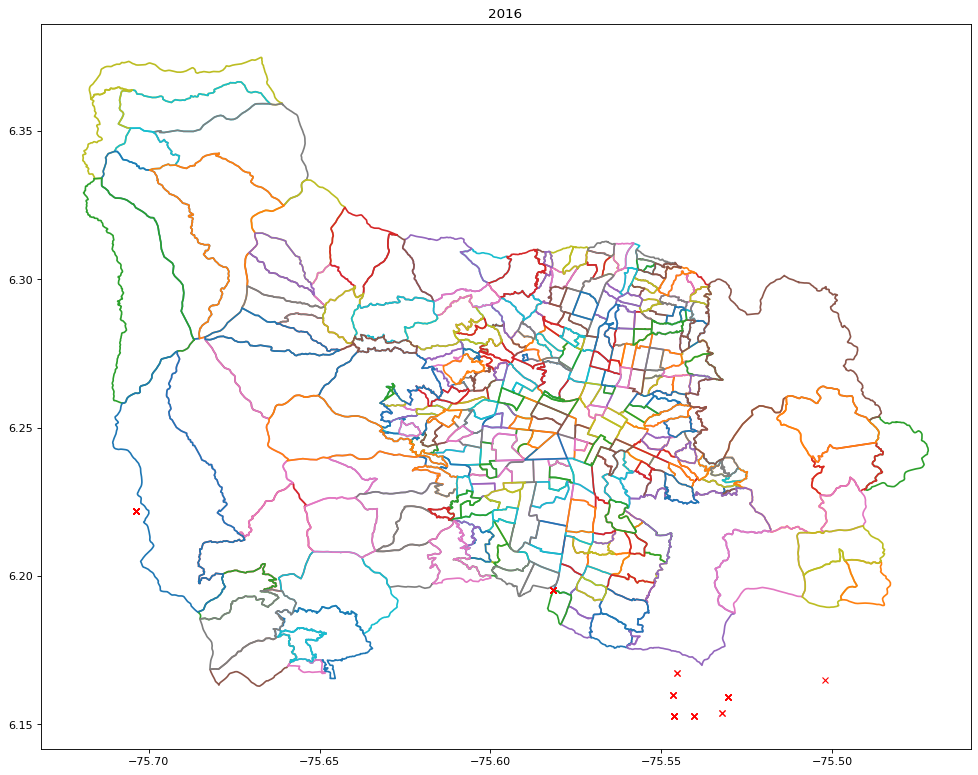

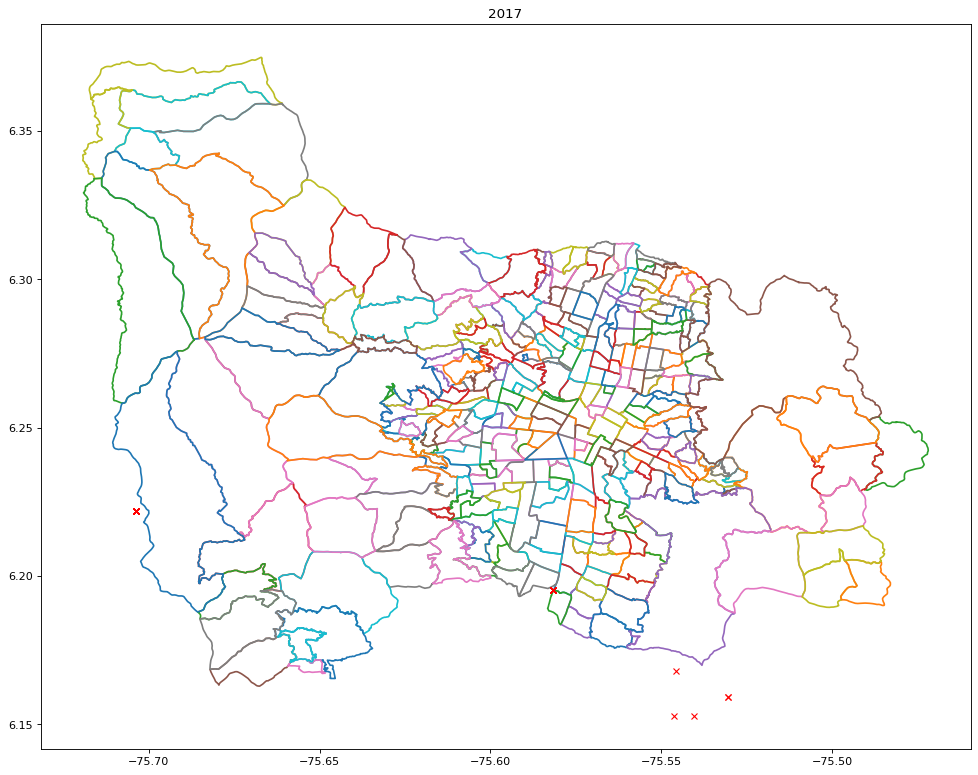

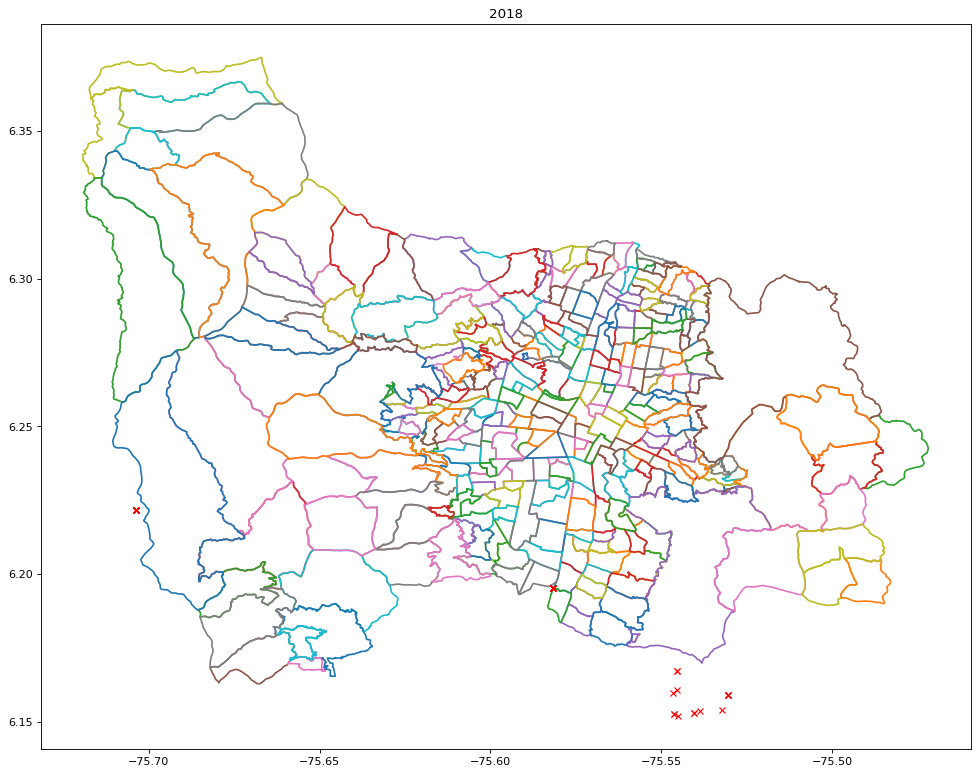

In [17]:
def set_barrio_comuna(row):
    if type(row['BARRIO']) == float:
        for barrio in barrios:
            point = Point(row['LONGITUD'], row['LATITUD'])
            if is_on_polygon(point, barrio['poligono']):
                row['BARRIO'] = barrio['barrio']
                row['COMUNA'] = barrio['comuna']
        if type(row['BARRIO']) == float:
            dx = point.x
            dy = point.y
            plt.plot(dx, dy, 'x', color='r')
    return row

mapa_medellin()
incidentes_2014 = incidentes_2014.apply(set_barrio_comuna, axis=1, result_type='expand')
plt.title("2014")
plt.show()
mapa_medellin()
incidentes_2015 = incidentes_2015.apply(set_barrio_comuna, axis=1, result_type='expand')
plt.title("2015")
plt.show()
mapa_medellin()
incidentes_2016 = incidentes_2016.apply(set_barrio_comuna, axis=1, result_type='expand')
plt.title("2016")
plt.show()
mapa_medellin()
incidentes_2017 = incidentes_2017.apply(set_barrio_comuna, axis=1, result_type='expand')
plt.title("2017")
plt.show()
mapa_medellin()
incidentes_2018 = incidentes_2018.apply(set_barrio_comuna, axis=1, result_type='expand')
plt.title("2018")
plt.show()

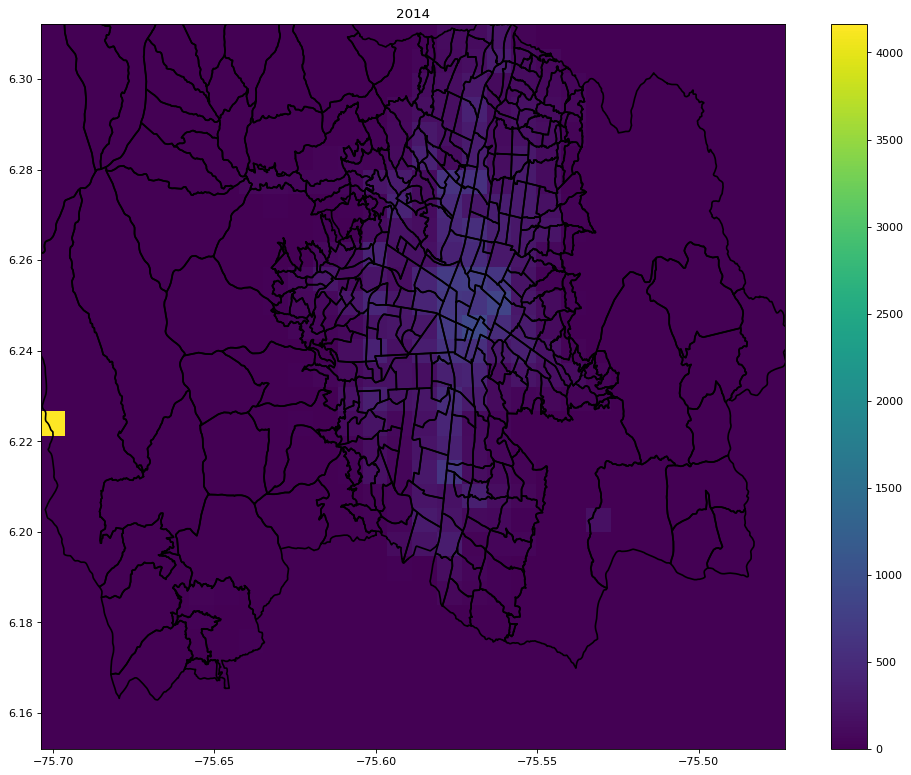

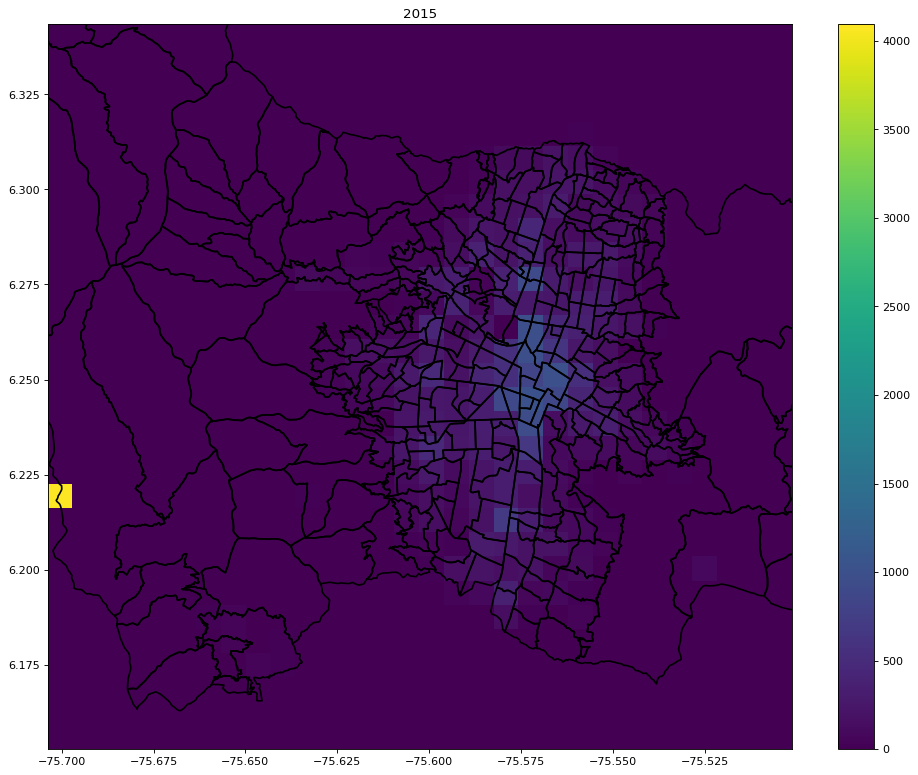

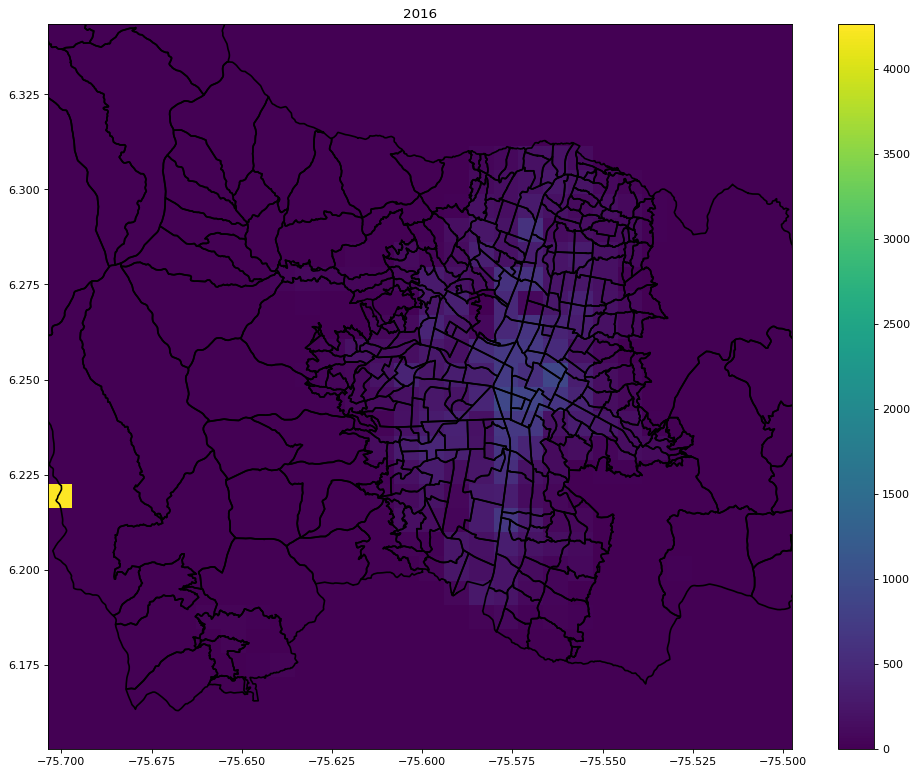

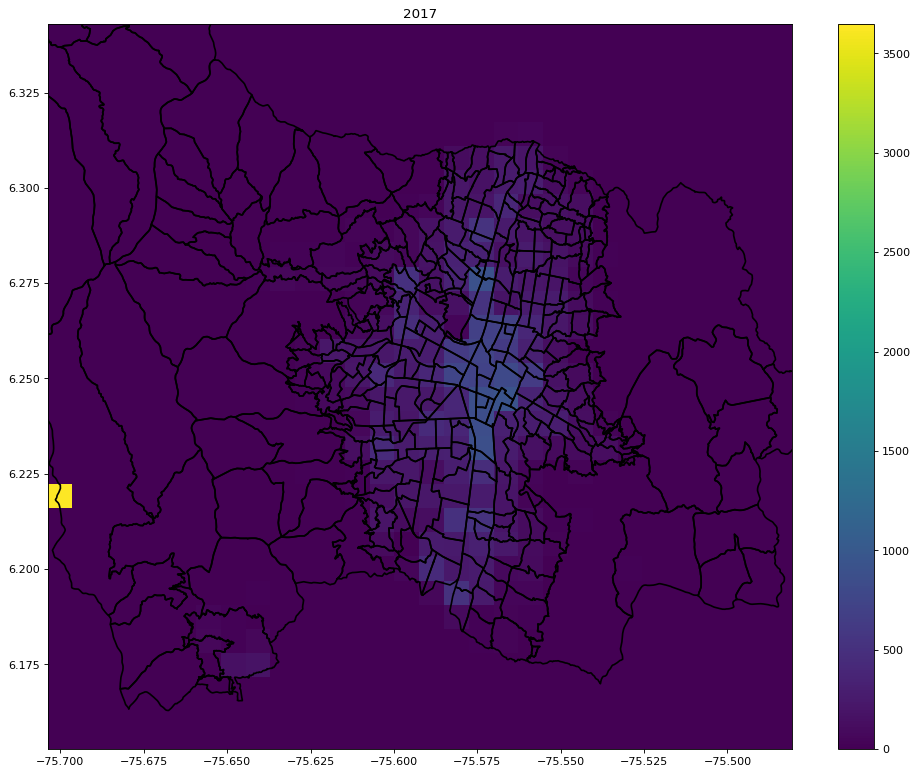

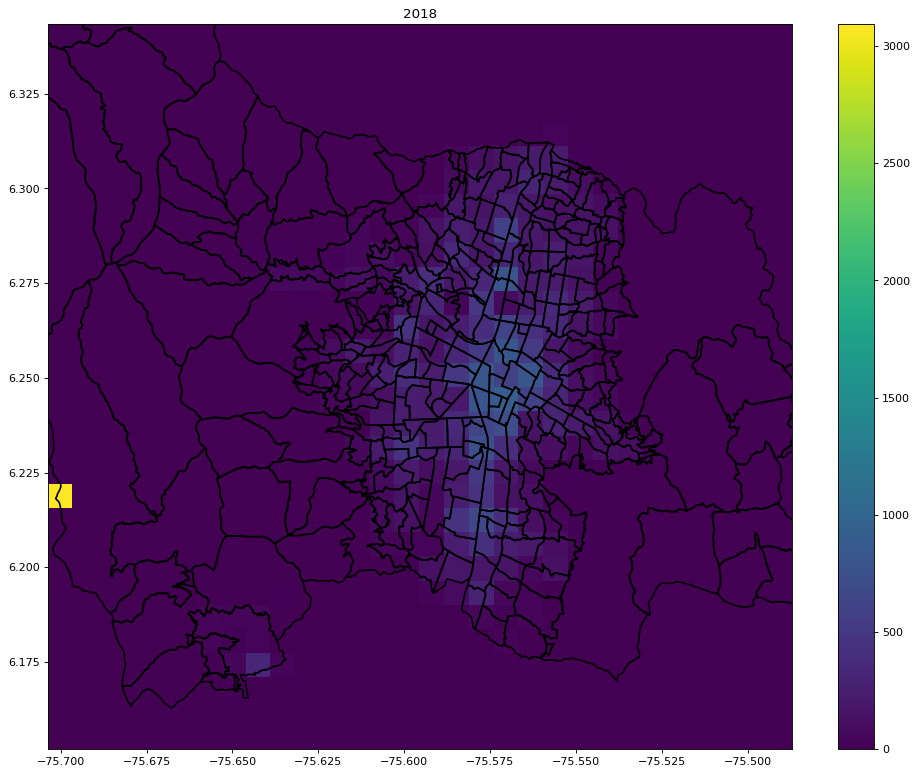

In [18]:
mapa_medellin('black')
plt.hist2d(incidentes_2014['LONGITUD'], incidentes_2014['LATITUD'], bins=30)
plt.title("2014")
plt.colorbar()
plt.show()

mapa_medellin('black')
plt.hist2d(incidentes_2015['LONGITUD'], incidentes_2015['LATITUD'], bins=30)
plt.title("2015")
plt.colorbar()
plt.show()

mapa_medellin('black')
plt.hist2d(incidentes_2016['LONGITUD'], incidentes_2016['LATITUD'], bins=30)
plt.title("2016")
plt.colorbar()
plt.show()

mapa_medellin('black')
plt.hist2d(incidentes_2017['LONGITUD'], incidentes_2017['LATITUD'], bins=30)
plt.title("2017")
plt.colorbar()
plt.show()

mapa_medellin('black')
plt.hist2d(incidentes_2018['LONGITUD'], incidentes_2018['LATITUD'], bins=30)
plt.title("2018")
plt.colorbar()
plt.show()

Del grafico anterior vemos, se puede notar como en las cercanias del corregimiento de San Antonio de Prado para cada año hay una gran densidad de observaciones las cuales corresponden a TIPO_GEOCOD como "No Ubicada", por lo cual es pertinente eliminar estos datos

In [19]:
incidentes_2014.drop(incidentes_2014[incidentes_2014['TIPO_GEOCOD'] == "No Ubicada"].index, inplace=True)
incidentes_2015.drop(incidentes_2015[incidentes_2015['TIPO_GEOCOD'] == "No Ubicada"].index, inplace=True)
incidentes_2016.drop(incidentes_2016[incidentes_2016['TIPO_GEOCOD'] == "No Ubicada"].index, inplace=True)
incidentes_2017.drop(incidentes_2017[incidentes_2017['TIPO_GEOCOD'] == "No Ubicada"].index, inplace=True)
incidentes_2018.drop(incidentes_2018[incidentes_2018['TIPO_GEOCOD'] == "No Ubicada"].index, inplace=True)

datos_faltantes = pd.DataFrame([
    incidentes_2014.isna().sum().to_dict(),
    incidentes_2015.isna().sum().to_dict(),
    incidentes_2016.isna().sum().to_dict(),
    incidentes_2017.isna().sum().to_dict(),
    incidentes_2018.isna().sum().to_dict(),
], index = ['2014', '2015', '2016', '2017', '2018'])
datos_faltantes

,X,Y,OBJECTID,RADICADO,FECHA,HORA,DIA,PERIODO,CLASE,DIRECCION,DIRECCION_ENC,CBML,TIPO_GEOCOD,GRAVEDAD,BARRIO,COMUNA,DISENO,DIA_NOMBRE,MES,MES_NOMBRE,X_MAGNAMED,Y_MAGNAMED,LONGITUD,LATITUD
2014,0,0,0,0,0,0,0,0,0,0,0,144,0,0,74,74,256,0,0,0,0,0,0,0
2015,0,0,0,0,0,0,0,0,1,0,0,114,0,0,67,67,250,0,0,0,0,0,0,0
2016,0,0,0,0,0,0,0,0,5,0,0,112,0,0,59,59,235,0,0,0,0,0,0,0
2017,0,0,0,2,0,0,0,0,0,0,0,66,0,0,45,45,227,0,0,0,0,0,0,0
2018,0,0,0,3,0,0,0,0,0,0,0,56,0,0,25,22,207,0,0,0,0,0,0,0


Como vemos, hemos reducido el numero de valores nulos para las variables barrio y comuna pero aun siguen existiendo algunas observaciones, si nos basamos en los graficos donde se pueden observar las observaciones que aun no tiene barrio ni comuna, vemos que estos son puntos a las afueras de Medellin, en concreto, vemos que gran parte de estas se ubican en La Palma, Envigado, por lo cual al no pertenecer a Medellin seran eliminados

In [20]:
incidentes_2014.drop(incidentes_2014[incidentes_2014['BARRIO'].isna()].index, inplace=True)
incidentes_2015.drop(incidentes_2015[incidentes_2015['BARRIO'].isna()].index, inplace=True)
incidentes_2016.drop(incidentes_2016[incidentes_2016['BARRIO'].isna()].index, inplace=True)
incidentes_2017.drop(incidentes_2017[incidentes_2017['BARRIO'].isna()].index, inplace=True)
incidentes_2018.drop(incidentes_2018[incidentes_2018['BARRIO'].isna()].index, inplace=True)

datos_faltantes = pd.DataFrame([
    incidentes_2014.isna().sum().to_dict(),
    incidentes_2015.isna().sum().to_dict(),
    incidentes_2016.isna().sum().to_dict(),
    incidentes_2017.isna().sum().to_dict(),
    incidentes_2018.isna().sum().to_dict(),
], index = ['2014', '2015', '2016', '2017', '2018'])
datos_faltantes

,X,Y,OBJECTID,RADICADO,FECHA,HORA,DIA,PERIODO,CLASE,DIRECCION,DIRECCION_ENC,CBML,TIPO_GEOCOD,GRAVEDAD,BARRIO,COMUNA,DISENO,DIA_NOMBRE,MES,MES_NOMBRE,X_MAGNAMED,Y_MAGNAMED,LONGITUD,LATITUD
2014,0,0,0,0,0,0,0,0,0,0,0,70,0,0,0,0,251,0,0,0,0,0,0,0
2015,0,0,0,0,0,0,0,0,1,0,0,47,0,0,0,0,249,0,0,0,0,0,0,0
2016,0,0,0,0,0,0,0,0,5,0,0,53,0,0,0,0,235,0,0,0,0,0,0,0
2017,0,0,0,2,0,0,0,0,0,0,0,21,0,0,0,0,226,0,0,0,0,0,0,0
2018,0,0,0,3,0,0,0,0,0,0,0,31,0,0,0,0,204,0,0,0,0,0,0,0


Creemos un nuevo campo con el que podamos trabajar de manera mas sencilla con la fecha y hora

In [21]:
# TODO

Ahora que tenemos nuestros datos mas limpios, generemos un archivo con esta informacon

In [22]:
# TODO

## Arreglo de 2017

Note que, para el 2017, se tiene que las comunas cuenta con datos de Barrios, veredas o lugares que pertenecen a una comuna. Asignemos a cada barrio la comuna correspondiente

In [23]:
barrio_vereda = pd.read_csv(BASE_PATH + '/data/Barrio_Vereda.csv')
barrio_vereda

,OBJECTID,CODIGO,NOMBRE,SUBTIPO_BARRIOVEREDA,NOMBRE_COMUNA_CORREGIMIENTO,SHAPEAREA,SHAPELEN
0,661,1422,La Aguacatala,1,El Poblado,6.220902e+05,3302.658052
1,662,0810,El Pinal,1,Villa Hermosa,4.134168e+05,3271.574553
2,663,0719,Fuente Clara,1,Robledo,2.364412e+05,3022.337658
3,664,0102,Santo Domingo Savio No.2,1,Popular,2.647505e+05,2943.707654
4,665,0302,Las Granjas,1,Manrique,6.413493e+05,3964.702306
...,...,...,...,...,...,...,...
327,972,1510,Guayabal,1,Guayabal,7.471972e+05,4132.516706
328,973,9006,Santa Elena Sector Central,2,Corregimiento de Santa Elena,3.229024e+06,9166.073911
329,910,0709,Córdoba,1,Robledo,2.348704e+05,2699.889112
330,926,8004,Yarumalito,2,Corregimiento de San Antonio de Prado,1.767097e+07,28170.981871


In [24]:
comunas = barrio_vereda['NOMBRE_COMUNA_CORREGIMIENTO'].unique()
comunas

array(['El Poblado', 'Villa Hermosa', 'Robledo', 'Popular', 'Manrique',
       'Buenos Aires', 'La Candelaria', 'Castilla', 'La América', 'Belén',
       'Doce de Octubre', 'San Javier', 'Aranjuez', 'Laureles Estadio',
       'Santa Cruz', 'Guayabal', nan,
       'Corregimiento de San Sebastián de Palmitas',
       'Corregimiento de Santa Elena', 'Corregimiento de Altavista',
       'Corregimiento de San Antonio de Prado',
       'Corregimiento de San Cristóbal'], dtype=object)

In [25]:
barrio_vereda[barrio_vereda['NOMBRE_COMUNA_CORREGIMIENTO'] == 'Castilla']

,OBJECTID,CODIGO,NOMBRE,SUBTIPO_BARRIOVEREDA,NOMBRE_COMUNA_CORREGIMIENTO,SHAPEAREA,SHAPELEN
9,670,0501,Toscana,1,Castilla,290053.954603,2574.004417
17,674,0513,Francisco Antonio Zea,1,Castilla,233064.848602,2257.010841
47,699,Inst_2,Oleoducto,1,Castilla,288176.605225,2502.948230
48,700,0505,Boyacá,1,Castilla,256398.894202,2595.971466
55,708,Inst_4,Terminal de Transporte,1,Castilla,215849.362104,2005.721343
85,718,0514,Alfonso López,1,Castilla,354326.109369,3119.208891
89,722,0517,Caribe,1,Castilla,601382.359267,3499.279090
93,753,0504,Tejelo,1,Castilla,423037.308122,3434.801937
96,756,Inst_1,Plaza de Ferias,1,Castilla,339279.597125,2625.524642
144,779,0510,Tricentenario,1,Castilla,420638.295286,2897.305761


In [26]:
def setNameComuna(row):
  if row['COMUNA'] not in comunas:
    comuna = barrio_vereda.loc[barrio_vereda['NOMBRE'] == row['COMUNA']]
    if comuna.empty:
      if row['COMUNA'] in ['Campo Valdés No. 1', 'Campo Valdés No. 2']:
        row['BARRIO'] = 'Campo Valdés No.1' if row['COMUNA'] == 'Campo Valdés No. 1' else 'Campo Valdés No.2'
        row['COMUNA'] = 'Manrique'
      elif row['COMUNA'] == 'Cabecera San Antonio de Prado':
        row['COMUNA'] = 'Corregimiento de San Antonio de Prado'
        row['BARRIO'] = 'San Antonio de Prado'
      else:
        row['COMUNA'] = np.NaN
        row['BARRIO'] = np.NaN
    else:
      row['COMUNA'] = list(comuna['NOMBRE_COMUNA_CORREGIMIENTO'].to_dict().values())[0]
  return row

incidentes_2017 = incidentes_2017.apply(setNameComuna, axis=1, result_type='expand')

## Creacion del conjunto de datos

In [29]:
incidentes = pd.concat([
    incidentes_2014,
    incidentes_2015,
    incidentes_2016,
    incidentes_2017,
    incidentes_2018
], ignore_index=True)
incidentes.isna().sum()

X                   0
Y                   0
OBJECTID            0
RADICADO            5
FECHA               0
HORA                0
DIA                 0
PERIODO             0
CLASE               6
DIRECCION           0
DIRECCION_ENC       0
CBML              222
TIPO_GEOCOD         0
GRAVEDAD            0
BARRIO             23
COMUNA             23
DISENO           1165
DIA_NOMBRE          0
MES                 0
MES_NOMBRE          0
X_MAGNAMED          0
Y_MAGNAMED          0
LONGITUD            0
LATITUD             0
dtype: int64

In [32]:
incidentes.to_csv(BASE_PATH + '/incidentes_medellin.csv', index=False) 